# Dog Breed Classification

This example is based on a very popular [Udacity project](https://github.com/udacity/dog-project), upgraded to use TensorFlow `2.3.0` with GPU accelaration. The goal is to classify images of dogs according to their breed.

In this notebook, we take the first steps towards developing an algorithm that could be used as part of a mobile or web app. At the end of this project, our code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. In this real-world setting, we will piece together a series of state-of-the-art computer vision models to perform different tasks (Dog detection -> Breed classification).

## Table of contents

We break the notebook into separate steps. Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Dependencies
* [Step 1](#step1): Import Datasets
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN (VGG16) to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN (ResNet-50) to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Own Dog Classifier
* [Step 7](#step7): Test Your Classifier

<a id='step0'></a>
## Step 0: Download Datasets and Install Dependencies

For this task we use TensorFlow `2.3.0`, as well as a few helper libraries like `Pillow`. Also, we need to download and extract the dataset we will use to train our classifier.

### Download the dataset

The dataset is available [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). The following cell downloads it as a zip file, extracts it and moves it to the corresponding folder. Finally, it removes the `zip` file.

In [1]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip -qo dogImages.zip
!mv dogImages dog_images
!rm dogImages.zip

### Install dependencies

The task requires `Pillow` the friendly PIL fork by [Alex Clark and Contributors](https://github.com/python-pillow/Pillow/graphs/contributors). PIL is the Python Imaging Library by Fredrik Lundh and Contributors. Below, we install the `Pillow` package using `pip`.

In [ ]:
!pip3 install --user -r requirements/requirements-v2.txt

### Import the necessary libraries

We use Tensorflow `2.3.0` to build and train our dog breed classifier. We also need `Pillow` to load the images in memory, which we specifically instruct to load any truncated images also.

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
from PIL import Image
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
print(f"Version of TensorFlow in use: {tf.__version__}")
print(f"Using GPU device: {tf.config.list_physical_devices('GPU')}")

Version of TensorFlow in use: 2.3.0
Using GPU device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<a id='step1'></a>
## Step 1: Import Datasets

First, let us define the pipeline-parameters cell. We use it to define the hyperparametes we would like to tune later. These variables will be converted to KFP pipeline parameters, so we should make sure they are used as global variables throughout the notebook.

In [5]:
LR = 6e-4
BATCH_SIZE = 32
NUMBER_OF_NODES = 256
EPOCHS = 4
IMG_SIZE = 224

### Processing the Dataset

We use TensorFlow native generators to load and transform the data. Pay attention to the `train_datagen` which also includes several transformations to augment our dataset (e.g. width and height shift, brightness alterations and horizontal flip). These transformations are taking place in memory, leaving the original data untouched.

In [6]:
def get_train_generator():
    data_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=.2,
        height_shift_range=.2,
        brightness_range=[0.5,1.5],
        horizontal_flip=True
    )
    return data_datagen.flow_from_directory(
        "dog_images/train/",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        
    )

def get_valid_generator():
    data_datagen = ImageDataGenerator(rescale=1./255)
    return data_datagen.flow_from_directory(
        "dog_images/valid/",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
    )

def get_test_generator():
    data_datagen = ImageDataGenerator(rescale=1./255)
    return data_datagen.flow_from_directory(
        "dog_images/test/",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE
    )

<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet V2](https://link.springer.com/chapter/10.1007/978-3-319-46493-0_38) model to detect dogs in images. First, we download a pretrained ResNet-50 model on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other computer vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of 1000 categories. Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
dog_classifier = tf.keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

The categories corresponding to dogs appear in an uninterrupted sequence referring to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'. Thus, in order to check if an image is predicted to contain a dog by the pre-trained ResNet model, we need only check if the function below returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `is_dog` function below, which returns True if a dog is detected in an image.

In [8]:
def is_dog(data):
    probs = dog_classifier.predict(data)
    preds = tf.argmax(probs, axis=1)
    return ((preds >= 151) & (preds <= 268))

To test the classifier we request a batch from our training data generator and feed it through the network. The accuracy, as expected, is really high.

In [9]:
train_generator = get_train_generator()
batch = train_generator.next()
predictions = is_dog(batch)

Found 6680 images belonging to 133 classes.


In [10]:
n_dog = np.sum(predictions)
dog_percentage = n_dog/BATCH_SIZE

print('{:.0%} of the files have a detected dog'.format(dog_percentage))

97% of the files have a detected dog


<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have a function for detecting dogs in images, we need a way to predict the dog breed from images. In this step, you will create a CNN that classifies dog breeds. We should be careful with adding too many trainable layers though. More parameters means longer training and you may also fall in the trap of overfitting. Thankfully, `tf.keras` provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Likewise, recall that labradors come in yellow, chocolate, and black. Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador  
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%. 

### Model architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing `model.summary()`.

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUMBER_OF_NODES, activation="relu"),
    tf.keras.layers.Dense(133, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0

The next step is to compile the model. For this, we need to pass an optimizer and a loss function. We can also pass a list of metrics we want. In this example, we pass the _accuracy_ metric.

In [13]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=LR),
    loss=tf.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

Finally, we can train the model using the `fit` method. This runs on batches yielded by the data generator and prints out the _loss_ and _accuracy_ both for train and validation sets.

In [14]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()

tb_callback = tf.keras.callbacks.TensorBoard(log_dir="custom_classifier_logs")

model.fit(train_generator, epochs=2,
    validation_data=valid_generator,
    callbacks=[tb_callback]
)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Epoch 1/2
  1/209 [..............................] - ETA: 0s - loss: 4.9004 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
209/209 [==============================] - 153s 730ms/step - loss: 4.8819 - accuracy: 0.0093 - val_loss: 4.8711 - val_accuracy: 0.0156
Epoch 2/2
209/209 [==============================] - 151s 725ms/step - loss: 4.8468 - accuracy: 0.0160 - val_loss: 4.8038 - val_accuracy: 0.0132


### Evaluation

To evaluate the final model we feed it with the test dataset and call the `evaluate` method.

In [15]:
test_generator = get_test_generator()

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"The accuracy in the test set is {test_accuracy:.3f}.")

Found 836 images belonging to 133 classes.
27/27 [==============================] - 7s 245ms/step - loss: 4.7878 - accuracy: 0.0167
The accuracy in the test set is 0.017.


<a id='step4'></a>
## Step 4: Create a CNN (VGG16) to Classify Dog Breeds (using Transfer Learning)

To reduce training time without sacrificing accuracy, we train a CNN using Transfer Learning. Transfer Learning is the fine-tuning of a network that was pre-trained on some big dataset with new classification layers. The idea behind is that we want to keep all the good features learned in the lower levels of the network (because there's a high probability the new images will also have those features) and just learn a new classifier on top of those. This tends to work well, especially with small datasets that don't allow for a full training of the network from scratch (it's also much faster than a full training).

One way of doing Transfer Learning is by loading a pretrained model up to a point, usually chopping off the final dense part of the model and adding a fully connected layer with the output that we want (e.g. an 133-node classifier). Then, we freeze the first part of the model (i.e. the body) and train only the final layer we added.

In [16]:
vgg_body = tf.keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [17]:
vgg_body.trainable = False

In [18]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# We make sure that the vgg_body is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = vgg_body(inputs, training=False)
# Convert features of shape `vgg_body.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier (categorical classification)
outputs = tf.keras.layers.Dense(133, activation="softmax")(x)

vgg_model = tf.keras.Model(inputs, outputs)

In [19]:
vgg_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 14,782,917
Trainable params: 68,229
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
vgg_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=LR),
    loss=tf.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [21]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()

vgg_model.fit(train_generator, epochs=2,
    validation_data=valid_generator
)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Epoch 1/2
209/209 [==============================] - 152s 727ms/step - loss: 4.8689 - accuracy: 0.0159 - val_loss: 4.7252 - val_accuracy: 0.0431
Epoch 2/2
209/209 [==============================] - 151s 721ms/step - loss: 4.6904 - accuracy: 0.0458 - val_loss: 4.5799 - val_accuracy: 0.0814


### Evaluation

To evaluate the model on the test set we call the same `evaluate` method.

In [22]:
test_generator = get_test_generator()

test_loss, test_accuracy = vgg_model.evaluate(test_generator)

print(f"The accuracy in the test set is {test_accuracy:.3f}.")

Found 836 images belonging to 133 classes.
27/27 [==============================] - 6s 225ms/step - loss: 4.5789 - accuracy: 0.0766
The accuracy in the test set is 0.077.


<a id='step5'></a>
## Step 5: Create a CNN (ResNet-50) to Classify Dog Breeds (using Transfer Learning)

In this section, we will use the same procedure but with a pretrained ResNet-50 model.

In [23]:
resnet_body = tf.keras.applications.ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

In [24]:
resnet_body.trainable = False

In [25]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
# We make sure that the vgg_body is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = resnet_body(inputs, training=False)
# Convert features of shape `vgg_body.output_shape[1:]` to vectors
x = tf.keras.layers.Flatten()(x)
# A Dense classifier (categorical classification)
outputs = tf.keras.layers.Dense(133, activation="softmax")(x)

resnet_model = tf.keras.Model(inputs, outputs)

In [26]:
resnet_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=LR),
    loss=tf.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [27]:
train_generator = get_train_generator()
valid_generator = get_valid_generator()

resnet_model.fit(train_generator, epochs=EPOCHS,
    validation_data=valid_generator
)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Epoch 1/4
209/209 [==============================] - 151s 725ms/step - loss: 13.0549 - accuracy: 0.4481 - val_loss: 8.7895 - val_accuracy: 0.6407
Epoch 2/4
209/209 [==============================] - 151s 724ms/step - loss: 9.8450 - accuracy: 0.6448 - val_loss: 9.3302 - val_accuracy: 0.6371
Epoch 3/4
209/209 [==============================] - 154s 739ms/step - loss: 8.1924 - accuracy: 0.7183 - val_loss: 9.5431 - val_accuracy: 0.7030
Epoch 4/4
209/209 [==============================] - 150s 718ms/step - loss: 7.1932 - accuracy: 0.7599 - val_loss: 11.2553 - val_accuracy: 0.7150


### Evaluation

In [28]:
test_generator = get_test_generator()

test_loss, test_accuracy = resnet_model.evaluate(test_generator)

print(f"The accuracy in the test set is {test_accuracy:.3f}.")

Found 836 images belonging to 133 classes.
27/27 [==============================] - 6s 234ms/step - loss: 10.7721 - accuracy: 0.7237
The accuracy in the test set is 0.724.


<a id='step6'></a>
## Step 6: Write your Own Dog Classifier

To create our own classifier we need a class to predict if there is a dog in the image and if that's true, return the breed. For the first part we use the `dog_classifier` method and then predict the breed using the `predict_breed` method.

In [29]:
idx_to_class = {value: key for key, value in train_generator.class_indices.items()}

def predict_breed(images):
    probs = resnet_model.predict(images)
    pred = tf.argmax(probs, axis=1)
    label = idx_to_class[pred.numpy()[0]]
    return label.split(".")[-1]

In [30]:
def predict_dog(image):
    image = image[None,...]
    if is_dog(image):
        pred =  predict_breed(image)
        print(f"This photo looks like a(n) {pred}.")
        return

    print("No dog detected")

image = train_generator.next()[0][0]
pred = predict_dog(image)

This photo looks like a(n) Poodle.


<a id='step7'></a>
## Step 7: Test Your Classifier

In the last section, we take your new algorithm for a spin; if you have a dog, does it predict your dog's breed accurately? If you have a cat, does it mistakenly think that your cat is a dog?

check_images/alaskan_malamute.jpg


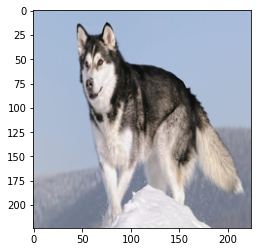

No dog detected
check_images/cat1.jpg


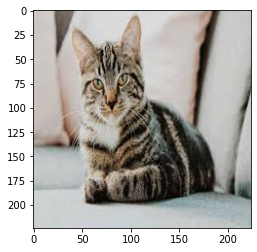

This photo looks like a(n) Poodle.
check_images/cat2.jpg


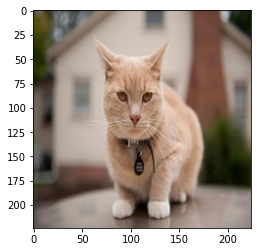

This photo looks like a(n) Poodle.
check_images/chow-chow.jpg


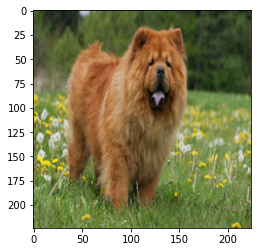

No dog detected
check_images/goat.jpg


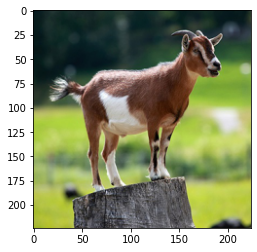

This photo looks like a(n) Poodle.
check_images/horse-dog.jpg


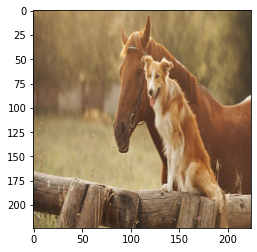

No dog detected
check_images/horse.jpg


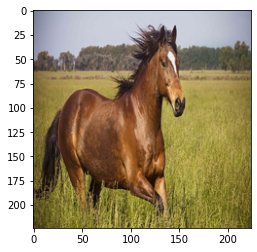

No dog detected
check_images/wolf.jpg


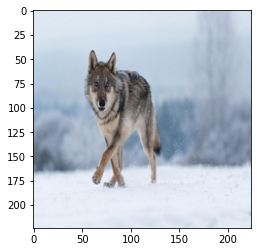

This photo looks like a(n) Poodle.


In [31]:
for img_path in sorted(glob("check_images/*")):
    print(img_path)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    
    plt.imshow(img)
    plt.show()
    
    img = np.array(img)
    predict_dog(img)